# Support Vector Machine Classifier

In [1]:
from common import get_prediction, split_data, get_data
import preprocessing as prep
import numpy as np

## Cargamos el dataset

In [2]:
data = get_data()
data.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


In [3]:
pred = get_prediction()
pred.head()

0    0
1    0
2    0
3    0
4    1
Name: volveria, dtype: int64

## Dividimos los datos

Separamos el holdout

In [4]:
X_train_val, X_holdout, y_train_val, y_holdout = split_data(data, pred)
X_train_val.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
239,normal,Señor Celestino Miguel,797,mujer,52.0,0,0,39687,3,adelante,fiumark_palermo
281,4d,Señora Reina Benita,141,mujer,NaN,0,2,489:,2,NaN,fiumark_chacarita
504,3d,Señor Emeterio de Jesus,309,hombre,33.0,1,0,"R1RR""55:3",3,NaN,fiumark_chacarita
230,4d,Señor Juan Jorge Alberto,158,hombre,33.0,0,0,"UQVQP1QS""5;42;2",1,NaN,fiumark_palermo
738,4d,Señor Pablo Augusto,495,hombre,24.0,0,0,"C16""675:2",1,NaN,fiumark_palermo


Separamos el validation

In [5]:
X_train, X_val, y_train, y_val = split_data(X_train_val, y_train_val)
X_train.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
475,4d,Señor Ignacio Nazar,689,hombre,21.0,0,0,572258,1,NaN,fiumark_palermo
247,4d,Señor Abel Omar,644,hombre,NaN,0,0,3823,6,NaN,fiumark_palermo
726,normal,Señor Fausto Rene,468,hombre,59.0,0,0,3359;4,3,NaN,fiumark_palermo
106,3d,Señora Irma Pascualina,707,mujer,48.0,0,0,4457;8,2,NaN,fiumark_palermo
206,4d,Señor Ovidio Valentin,871,hombre,29.0,0,0,56;46:,1,NaN,fiumark_palermo


## Entrenamos los modelos

Al igual que KNN, para este modelo se entrenara de 3 formas distintas.

Preparamos los preprocesados

In [6]:
# Con la columna fila
prep_base_1 = prep.Preprocessing(
    [prep.Drop_high_cardinals(), prep.Dummy_variables()]
)

# Rellenado de nan con zeros
prep_1 = prep.Preprocessing(
    [prep_base_1, prep.Nan_to_zero()]
)

# Rellenado de nan con la media
prep_2 = prep.Preprocessing(
    [prep_base_1, prep.Nan_to_mean()]
)

# Rellenado de nan con la moda
prep_3 = prep.Preprocessing(
    [prep_base_1, prep.Nan_to_mode()]
)

# Rellenado de nan con la median
prep_4 = prep.Preprocessing(
    [prep_base_1, prep.Nan_to_median()]
)

In [7]:
# Sin la columna fila
prep_base_2 = prep.Preprocessing(
    [prep.Drop_high_cardinals(), prep.Drop_column_nan(), prep.Dummy_variables()]
)

# Rellenado de nan con zeros
prep_5 = prep.Preprocessing(
    [prep_base_2, prep.Nan_to_zero()]
)

# Rellenado de nan con la media
prep_6 = prep.Preprocessing(
    [prep_base_2, prep.Nan_to_mean()]
)

# Rellenado de nan con la moda
prep_7 = prep.Preprocessing(
    [prep_base_2, prep.Nan_to_mode()]
)

# Rellenado de nan con la median
prep_8 = prep.Preprocessing(
    [prep_base_2, prep.Nan_to_median()]
)

In [8]:
list_preprocessing = [
    # con la columna fila
    prep_1, prep_2, prep_3, prep_4,
    # sin la columna fila
    prep_5, prep_6, prep_7, prep_8
]

### 1. Modelo sin estandarizar ni normalizar

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from common import super_training

params = {
    'C': np.arange(1, 10),
    'degree': np.arange(1, 5, 0.1),
    'coef0': np.arange(1, 20),
    'kernel': ['linear', 'rbf', 'poly']
}

# Demora 30m aproximadamente
models_preprocessing = super_training(
    X_train, y_train, list_preprocessing,
    RandomizedSearchCV(
        SVC(probability=True), params, n_iter=30, 
        random_state=20, scoring='roc_auc', n_jobs=-1, cv=5
    )
)

In [10]:
from common import get_proba_predicts

proba_predicts = get_proba_predicts(models_preprocessing, X_val)

<Figure size 432x288 with 0 Axes>

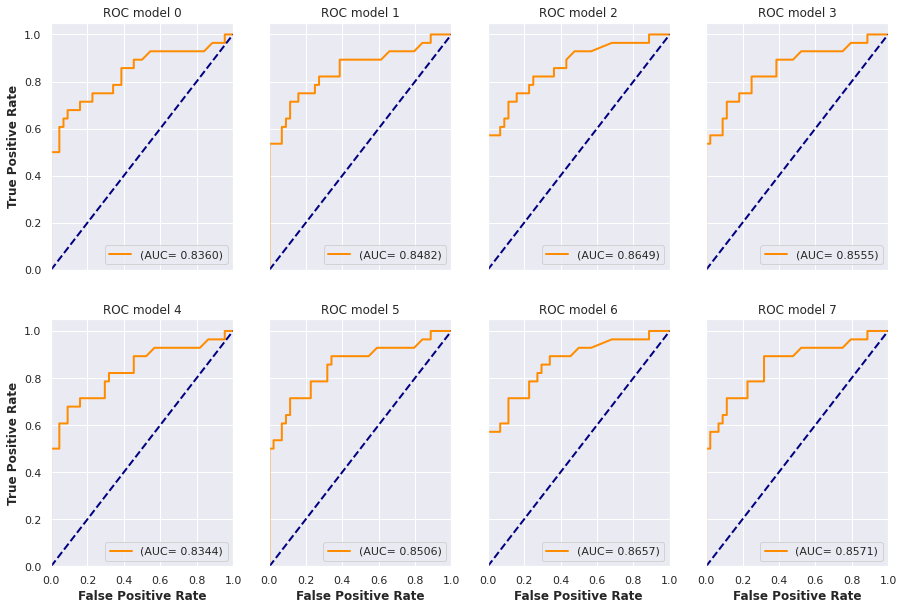

In [11]:
from common import plot_rocs

best_model_index = plot_rocs(proba_predicts, y_val, 4, 2)

Podemos ver que el mejor modelo es el modelo 6.

In [12]:
best_svc_prep = models_preprocessing[best_model_index]

Con el siguiente preprocesado

In [13]:
best_svc_prep[1].function()

Elimina las columnas con alta cardinalidad
Elimina las columnas con un porcentaje de valores nan mayor igual al 70%
Transforma las variables categoricas en dummy variables
Rellena los nan de edad con la moda


Veremos que pasa si normalizamos los datos.

### 2. Modelo con media 0

In [14]:
list_preprocessing_norm = []
# Se agregara la normalizacion de los datos a los preprocesados anteriores 42
for p in list_preprocessing:
    list_preprocessing_norm.append(
        prep.Preprocessing(
            [p, prep.Normalizer_columns()]
        )
    )

In [15]:
params = {
    'C': np.arange(1, 10),
    'gamma': np.arange(0, 1, 0.1),
    'degree': np.arange(1, 5, 0.1),
    'coef0': np.arange(1, 10),
    'kernel': ['linear', 'rbf', 'poly']
}

models_preprocessing_norm = super_training(
    X_train, y_train, list_preprocessing_norm,
    RandomizedSearchCV(
        SVC(probability=True), params, n_iter=60, 
        random_state=20, scoring='roc_auc', n_jobs=-1, cv=5
    )
)

In [16]:
proba_predicts = get_proba_predicts(models_preprocessing_norm, X_val)

<Figure size 432x288 with 0 Axes>

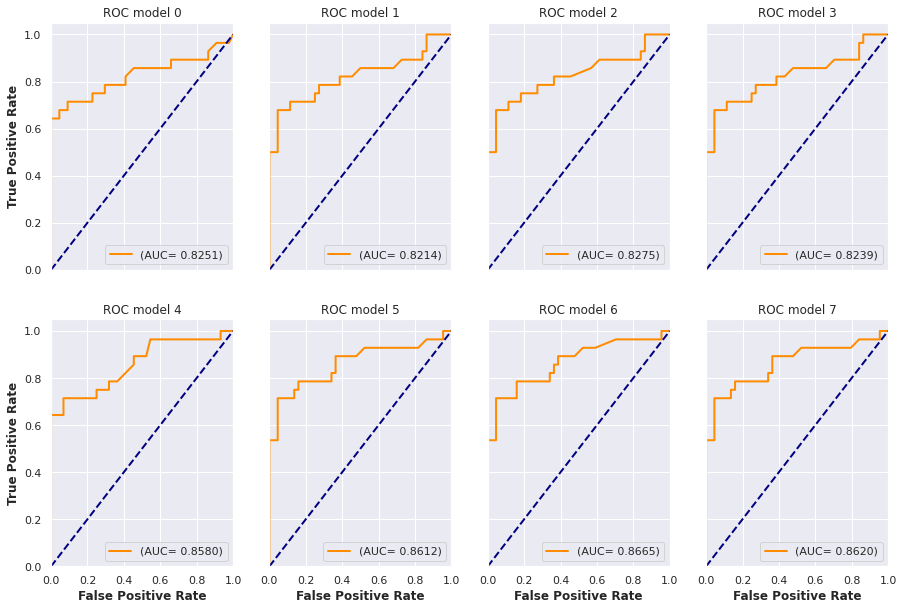

In [17]:
best_model_index = plot_rocs(proba_predicts, y_val, 4, 2)

Vemos que el mejor modelo es el modelo 6.

In [18]:
best_svc_prep_norm = models_preprocessing_norm[best_model_index]

Con el siguiente preprocesado

In [19]:
best_svc_prep_norm[1].function()

Elimina las columnas con alta cardinalidad
Elimina las columnas con un porcentaje de valores nan mayor igual al 70%
Transforma las variables categoricas en dummy variables
Rellena los nan de edad con la moda
Normaliza los atributos no binarios


Veremos que pasa si estandarizamos los datos.

### 3. Modelo con media 0 y varianza 1

In [20]:
list_preprocessing_std = []
# Se agregara la estandarizacion de los datos a los preprocesados anteriores | 4
for p in list_preprocessing:
    list_preprocessing_std.append(
        prep.Preprocessing(
            [p, prep.Std_columns()]
        )
    )

In [21]:
params = {
    'C': np.arange(1, 10),
    'gamma': np.arange(0, 1, 0.1),
    'degree': np.arange(1, 5, 0.1),
    'coef0': np.arange(1, 10),
    'kernel': ['linear', 'rbf', 'poly']
}

models_preprocessing_std = super_training(
    X_train, y_train, list_preprocessing_std,
    RandomizedSearchCV(
        SVC(probability=True), params, n_iter=30, 
        random_state=20, scoring='roc_auc', n_jobs=-1, cv=5
    )
)

In [22]:
proba_predicts = get_proba_predicts(models_preprocessing_std, X_val)

<Figure size 432x288 with 0 Axes>

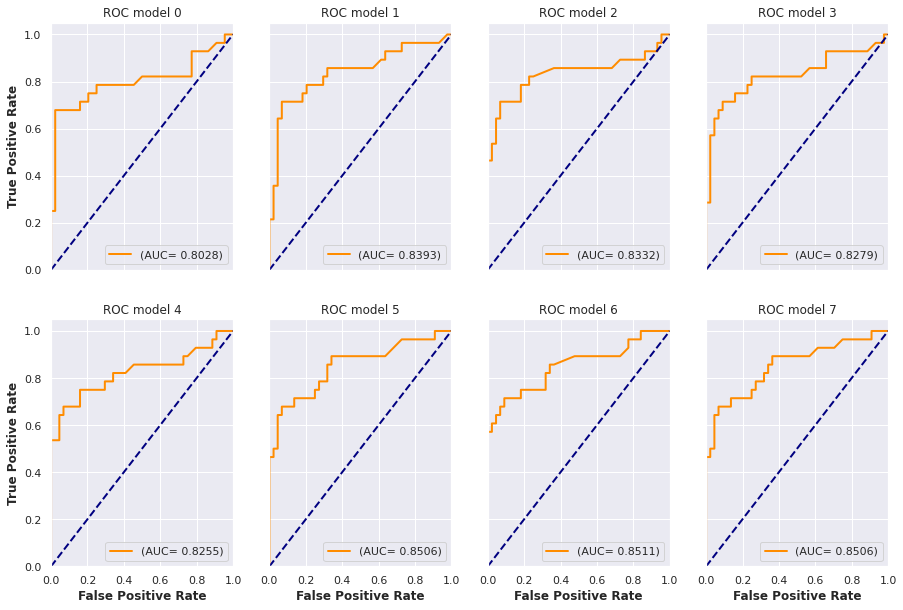

In [23]:
best_model_index = plot_rocs(proba_predicts, y_val, 4, 2)

Podemos ver que el mejor modelo tambien es el modelo 6.

In [24]:
best_svc_prep_std = models_preprocessing_std[best_model_index]

Con el siguiente preprocesado

In [25]:
best_svc_prep_std[1].function()

Elimina las columnas con alta cardinalidad
Elimina las columnas con un porcentaje de valores nan mayor igual al 70%
Transforma las variables categoricas en dummy variables
Rellena los nan de edad con la moda
Estandariza los atributos no binarios


## Escogemos el mejor modelo

In [26]:
models_prep_final = [best_svc_prep, best_svc_prep_norm, best_svc_prep_std]

proba_predicts = get_proba_predicts(models_prep_final, X_val)

<Figure size 432x288 with 0 Axes>

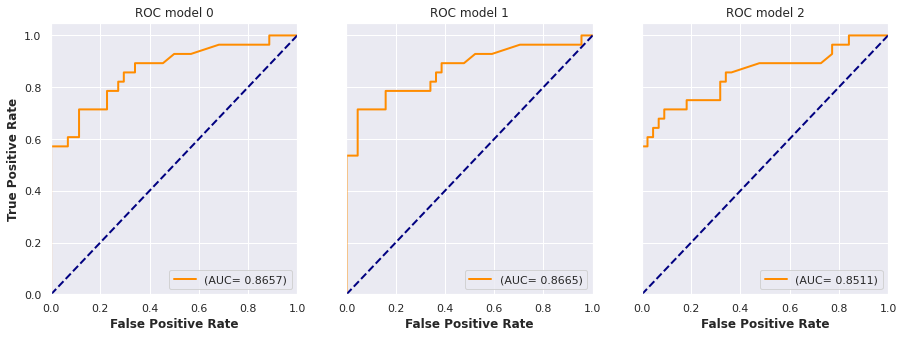

In [27]:
best_model_index = plot_rocs(proba_predicts, y_val, 3, 1)

El mejor modelo de todos resultó ser el modelo en el que los datos fueron normalizados antes de entrenar.

In [28]:
best_svc, preprocessing = models_prep_final[best_model_index]
best_svc.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 5,
 'decision_function_shape': 'ovr',
 'degree': 2.5000000000000013,
 'gamma': 0.4,
 'kernel': 'poly',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Con el siguiente preprocesado.

In [29]:
preprocessing.function()

Elimina las columnas con alta cardinalidad
Elimina las columnas con un porcentaje de valores nan mayor igual al 70%
Transforma las variables categoricas en dummy variables
Rellena los nan de edad con la moda
Normaliza los atributos no binarios


## Vemos las metricas del mejor modelo

Preprocesamos

In [30]:
X_holdout_ = preprocessing.transform(X_holdout)
X_holdout_.head()

,edad,amigos,parientes,precio_ticket,tipo_de_sala_4d,tipo_de_sala_normal,genero_mujer,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
713,0.947943,0.000000,0.039498,0.315981,0,1,0,1,0,0.0
370,0.998969,0.000000,0.000000,0.045408,1,0,0,1,0,0.0
114,0.996056,0.028058,0.000000,0.084174,0,0,0,0,0,0.0
323,0.998969,0.000000,0.000000,0.045408,1,0,1,0,1,0.0
131,0.889001,0.000000,0.254000,0.381000,1,0,1,1,0,0.0


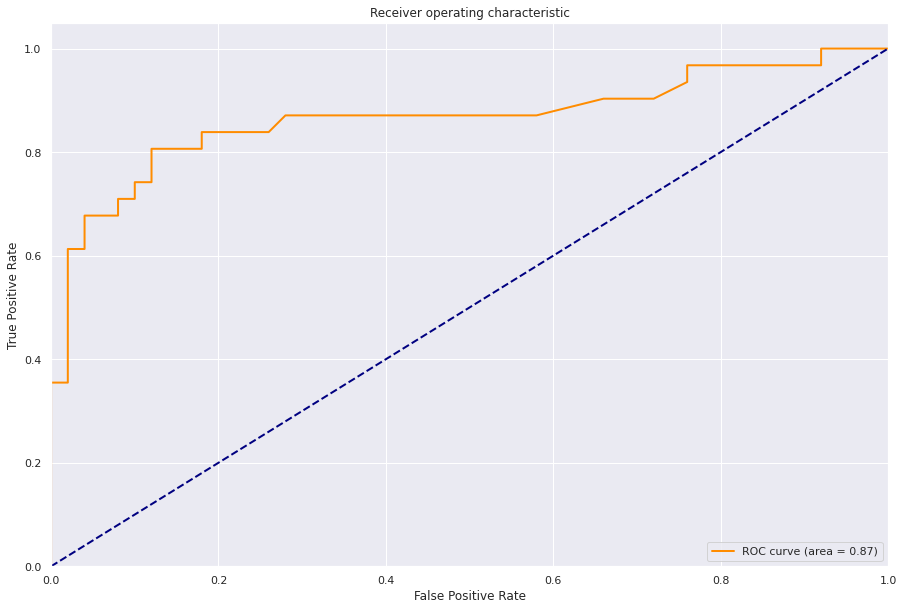

0.8661290322580646

In [31]:
from common import plot_roc
plot_roc(y_holdout, best_svc.predict_proba(X_holdout_)[:,1])

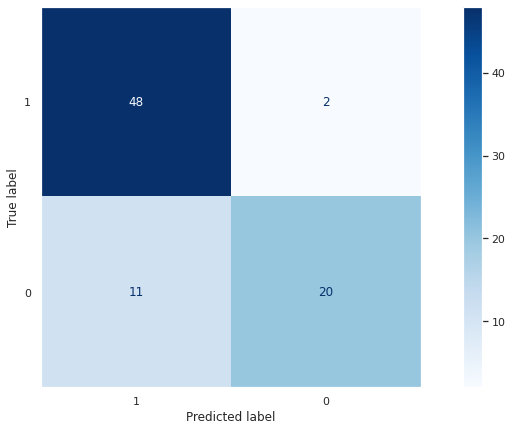

In [32]:
from common import plot_confusion
plot_confusion(
    best_svc, 
    X_holdout_, 
    y_holdout
)

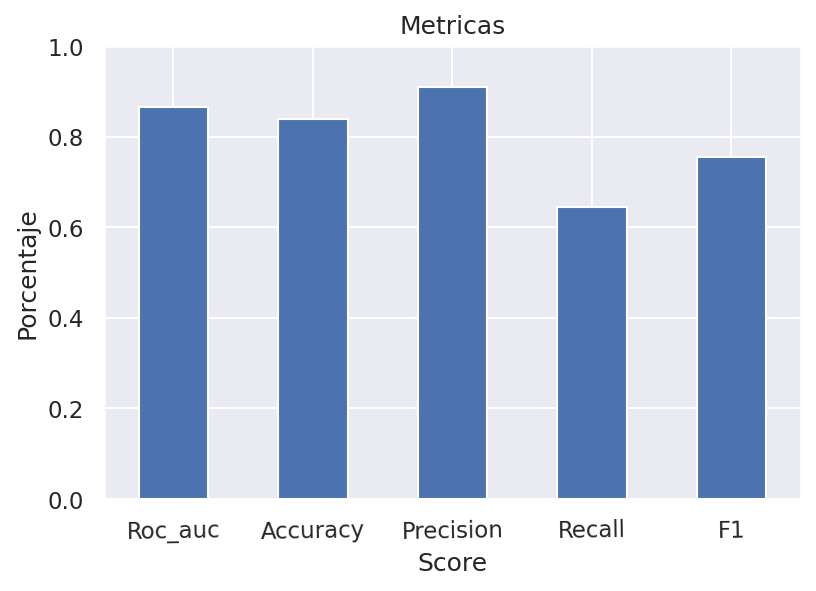

Roc_auc      0.866129
Accuracy     0.839506
Precision    0.909091
Recall       0.645161
F1           0.754717
dtype: float64

In [33]:
from common import plot_metrics
plot_metrics(
    y_holdout, 
    best_svc.predict_proba(X_holdout_)[:,1], 
    best_svc.predict(X_holdout_)
)

# Hacemos la predicción sobre el holdout de la empresa

In [34]:
from common import get_holdout
X_holdout_empresa = get_holdout()
X_holdout_empresa.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señorita Beatriz Estela,650,mujer,26.0,0,0,"EC0""4536",1,NaN,fiumark_palermo
1,4d,Señorita Elena Herminda,234,mujer,8.0,4,2,569299,4,NaN,fiumark_palermo
2,normal,Señor Humberto Americo,31,hombre,43.0,0,0,"RE""39823",3,NaN,fiumark_chacarita
3,3d,Señor Casiano,552,hombre,30.0,0,0,46657:,3,NaN,fiumark_palermo
4,4d,Señor Gregorio Nicolas,411,hombre,NaN,0,0,56;444,1,NaN,fiumark_palermo


Preprocesamos el holdout de la empresa con el mejor preprocesamiento para este modelo y separamos 

In [35]:
ussers = X_holdout_empresa['id_usuario']
X_holdout_empresa_ = prep.Preprocessing_SVM().transform(X_holdout_empresa)
X_holdout_empresa_.head()

,edad,amigos,parientes,precio_ticket,tipo_de_sala_4d,tipo_de_sala_normal,genero_mujer,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,0.999261,0.0,0.0,0.038433,1,0,1,1,0,0.0
1,0.800000,0.4,0.2,0.400000,1,0,1,1,0,0.0
2,0.997575,0.0,0.0,0.069598,0,1,0,0,0,0.0
3,0.995037,0.0,0.0,0.099504,0,0,0,1,0,0.0
4,0.989949,0.0,0.0,0.141421,1,0,0,1,0,0.0


Predecimos con el mejor modelo

In [36]:
volveria = best_svc.predict(X_holdout_empresa_)
volveria

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0])

Generamos el dataframe de las predicciones

In [37]:
import pandas as pd
predictions = pd.DataFrame({
    'id_usuario': ussers, 
    'volveria': volveria
})
predictions.head()

,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0


Guardamos el archivo

In [38]:
predictions.to_csv(
    'SVMClassifier.csv', 
    columns=predictions.columns, 
    index=False
)